In [502]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime 
import calendar
from googletrans import Translator
from math import sin,cos,atan2,sqrt,radians,asin
from datetime import datetime 
import calendar
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [503]:
###load training and test data and also calculate the missing values#############
train = pd.read_csv("train_cab.csv")
test = pd.read_csv("test.csv")

print("missing values in train",train.isnull().sum().sort_values(ascending=False))
print("missing value in test",test.isnull().sum().sort_values(ascending=False))

missing values in train passenger_count      55
fare_amount          24
dropoff_latitude      0
dropoff_longitude     0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
dtype: int64
missing value in test passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
dtype: int64


In [504]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


In [505]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [506]:
train.describe()

''' based on the analysis , the latitude and logitude values are matching with the newyork coordinates hence we can 
    that the cab fare should be calculated in the newyork city

'''
lat_min=37
lat_max=45.0153
lon_min=-79.7624
lon_max=-71.7517

print(lat_min,',',lat_max)
print(lon_min,',',lon_max)

37 , 45.0153
-79.7624 , -71.7517


In [507]:
### methods that are used for data cleaning and exploratory data analysis

def data_cleaning_stage_cooridnates(df):
    
    #make the co-ordinates which are out of range to null and remove those records later
    df['pickup_latitude']=df.apply(lambda row: np.nan if((row['pickup_latitude'] < lat_min)|(row['pickup_latitude']> lat_max)) else row['pickup_latitude'],axis=1)
    df['dropoff_latitude']=df.apply(lambda row: np.nan if((row['dropoff_latitude'] < lat_min)|(row['dropoff_latitude']> lat_max)) else row['pickup_latitude'],axis=1)
    df['pickup_longitude']=df.apply(lambda row: np.nan if((row['pickup_longitude'] < lon_min)|(row['pickup_longitude']> lon_max)) else row['pickup_longitude'],axis=1)
    df['dropoff_longitude']=df.apply(lambda row: np.nan if((row['dropoff_longitude'] < lon_min)|(row['dropoff_longitude']> lon_max)) else row['dropoff_longitude'],axis=1)

    #function to calculate distance bewteen 2 cooridinates    
    def calculateDistance(lat1,long1,lat2,long2):
        radius = 6371
        dlat = np.abs(np.radians(lat1)-np.radians(lat2))
        dlong = np.abs(np.radians(long1)-np.radians(long2))
        t1 = (np.sin(dlat/2)**2)+(np.cos(radians(lat1))*np.cos(radians(lat2))*np.sin(dlong/2)**2)
        t2 = 2*(atan2(np.sqrt(t1),np.sqrt(1-t1)))
        return radius*t2
    
    #call to distance function to calculate based on the latitude and longitude values provided
    df['distance']=df.apply(lambda row:calculateDistance(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']),axis=1)      
    
    print("end of the co_ordinates preprocessing")
    return df


def calculateDateTime(df):
    mode_dt = df['pickup_datetime'].mode()[0]
    print(mode_dt)
    
    #replace the date string with mode if the date doesnot match
    def date_validation(str1):
        r = re.compile('[1-2][0-9][0-9][0-9]-[0-1][0-9]-[0-3][0-9] [0-2][0-3]:[0-5][0-9]:[0-5][0-9] UTC')
        if r.match(str1):           
            return str1
        else:
            return mode_dt
        
    def time_date_outliers(value,x,lower,upper):
        value = int(value)
        if (value < lower|value > upper):
            return int(df[x].mode())
        return int(value)
    
    df['pickup_datetime']=df.apply(lambda row:date_validation(str(row['pickup_datetime'])),axis=1)
    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    df['day_week']=df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    df['date']= df['pickup_datetime'].dt.date
    df['day']=df['pickup_datetime'].apply(lambda x:x.day)
    df['hr']=df['pickup_datetime'].apply(lambda x:x.hour)
    df['month']=df['pickup_datetime'].apply(lambda x:x.month)
    df['year']=df['pickup_datetime'].apply(lambda x:x.year)
    
    #month validation
    df["month"]=df.apply(lambda row: time_date_outliers(row["month"],"month",1,12) if (row["month"] not in range(0,13)) else row["month"],axis=1)
        
    #day validation
    df["day"]=df.apply(lambda row: time_date_outliers(row["day"],"day",1,30) if (row["month"] in [4,6,9,11]) else row["month"],axis=1)
    df["day"]=df.apply(lambda row: time_date_outliers(row["day"],"day",1,31) if (row["month"] in [1,3,5,7,8,10,12]) else row["month"],axis=1)
    df["day"]=df.apply(lambda row: time_date_outliers(row["day"],"day",1,31) if (row["month"] == 2) else row["month"],axis=1)
    
    print("end of date time validation")
    #df=df.drop('pickup_datetime',axis=1)
    return df

def calculateFare(df):
    df['fare_amount']=df['fare_amount'].astype(np.float64)
    fare = train['distance'].max()*1.56+52
    ''' the fare can be at max of 250$ , considering airport as highest fare and on computation the max fare is 165$'''
    return df[(df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 250)]

#assuming that maximum passengers in cab would be 6 and if it considered as bus it is 12, replace the other values with null
def calculatePassengerCount(df):
    
    m = df[(df['passenger_count']>=1)|(df['passenger_count']<=6)]['passenger_count'].mode()
    df['passenger_count']=df.apply(lambda row:  m if (row['passenger_count'] not in range(1,7)) else row['passenger_count'],axis=1)
    return df 

#replace the string with npa if it contains any apart from numericals
def string_validation(str1):
        if type(str1)==type('string'):
            r = re.compile('.*[(+*)-]|[A-Z]|[a-b].*')
            if r.match(str1):           
                return np.nan
            else:
                return float(str1)
            
#convert the set of columns to float            
def convert_to_float(df,float_columns):
    for i in float_columns:
        df[i]=df[i].astype(float)
    return df

#identify the missing values and drop off
def missing_values(df):
    for i in df.columns:
        if(df[i].isnull().sum() != 0):
            print(i,":missing values before drop:",df[i].isnull().sum())
            df=df.drop(df[df[i].isnull()].index,axis=0)
            print(i,":missing values after drop:",df[i].isnull().sum())
    return df  


In [508]:
#type conversions of train data
float_columns=['pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude']
train['fare_amount']=train.apply(lambda row:string_validation(row['fare_amount']),axis=1)
train=convert_to_float(train,float_columns)

In [509]:
#DateTime validation and EDA of train data

''' if the latitude and logitude value are incorrect that data has no value hence we will be droping all the rows
that are out of newyork city range. The same with the target variable : fare_amount

'''
train=calculateDateTime(train)
#latitude and longitude validation and also distance calculation
train=data_cleaning_stage_cooridnates(train)
#Passenger count validation
train=calculatePassengerCount(train)
#drop the list of missing values
train=missing_values(train)
#convert the values
train['passenger_count']=train['passenger_count'].astype(int)

train = calculateFare(train)

2009-04-18 20:44:00 UTC
end of date time validation
end of the co_ordinates preprocessing
fare_amount :missing values before drop: 28
fare_amount :missing values after drop: 0
pickup_longitude :missing values before drop: 322
pickup_longitude :missing values after drop: 0
pickup_latitude :missing values before drop: 1
pickup_latitude :missing values after drop: 0
dropoff_longitude :missing values before drop: 12
dropoff_longitude :missing values after drop: 0
dropoff_latitude :missing values before drop: 1
dropoff_latitude :missing values after drop: 0


In [510]:
#DateTime validation and EDA of test data
test=calculateDateTime(test)
#latitude and longitude validation and also distance calculation
test=data_cleaning_stage_cooridnates(test)
#drop the list of missing values
test=missing_values(test)
#Passenger count validation
test=calculatePassengerCount(test)
#type conversion od test data
test=convert_to_float(test,float_columns)
test['passenger_count']=test['passenger_count'].astype(int)

2011-12-13 22:00:00 UTC
end of date time validation
end of the co_ordinates preprocessing


In [511]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hr,month,year,distance
count,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000,15696.000000
mean,11.298077,-73.974835,40.750901,-73.973863,40.750901,1.645005,5.170808,16.770387,5.170808,2010.399083,1.962285
std,9.597119,0.041506,0.037971,0.039350,0.037971,1.262036,2.722191,6.401340,2.722191,1.900288,3.201860
min,2.500000,-74.438233,39.603178,-74.429332,39.603178,1.000000,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992394,40.736588,-73.991373,40.736588,1.000000,4.000000,13.000000,4.000000,2009.000000,0.511298
50%,8.500000,-73.982067,40.753302,-73.980575,40.753302,1.000000,4.000000,20.000000,4.000000,2009.000000,1.075981
75%,12.500000,-73.968110,40.767801,-73.965460,40.767801,2.000000,6.000000,20.000000,6.000000,2012.000000,2.045075
max,180.000000,-73.137393,41.366138,-73.137393,41.366138,6.000000,12.000000,23.000000,12.000000,2015.000000,72.064418


In [512]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hr,month,year,distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751041,1.671273,9.247932,17.675106,9.247932,2011.524612,1.966889
std,0.042774,0.033541,0.039072,0.033541,1.278747,3.593859,7.321696,3.593859,1.354925,3.090070
min,-74.252193,40.573143,-74.263242,40.573143,1.000000,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.736125,1.000000,6.000000,13.000000,6.000000,2011.000000,0.535192
50%,-73.982326,40.753051,-73.980015,40.753051,1.000000,12.000000,22.000000,12.000000,2011.000000,1.105076
75%,-73.968013,40.767113,-73.964059,40.767113,2.000000,12.000000,22.000000,12.000000,2012.000000,2.068584
max,-72.986532,41.709555,-72.990963,41.709555,6.000000,12.000000,23.000000,12.000000,2015.000000,70.864476


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of Trip Fare')

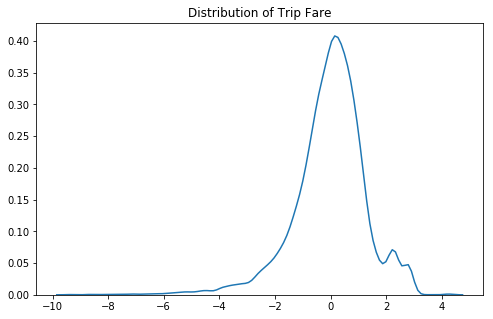

In [513]:
'''Exploratory data analyis  the major variables are fare_amount , distance , passenger count '''

plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['distance'].values)).set_title("Distribution of Trip Fare")

(-74.03, -73.75)

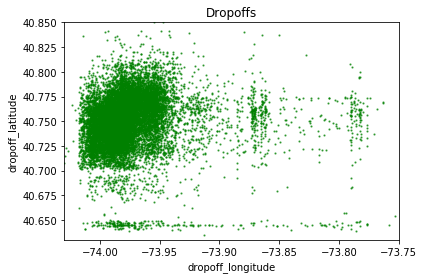

In [514]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=1.5, alpha=.6)
plt.title("Dropoffs")
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

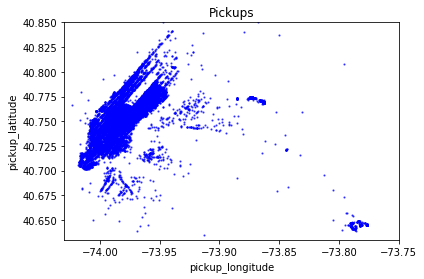

In [515]:
train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=1.5, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

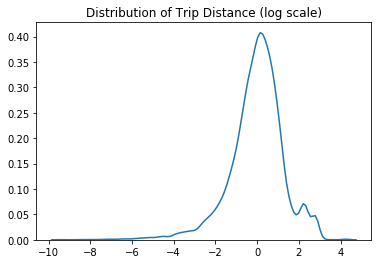

In [516]:
#scaling of the distance is good it is normally distributed
sns.kdeplot(np.log(train['distance'].values)).set_title("Distribution of Trip Distance (log scale)")

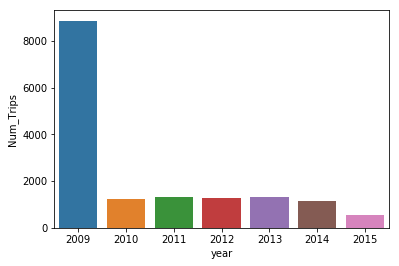

In [517]:
trips_year=train.groupby(['year'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'Num_Trips'})
trips_year.head()
sns.barplot(x='year',y='Num_Trips',data=trips_year)

Text(0.5, 1.0, 'Avg Fare Amount over Years')

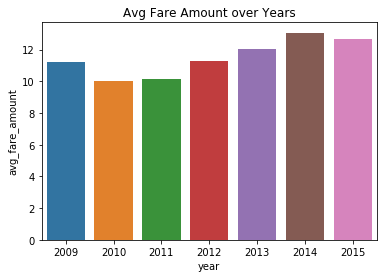

In [518]:
trips_year_fareamount=train.groupby(['year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")

Text(0, 0.5, 'Count')

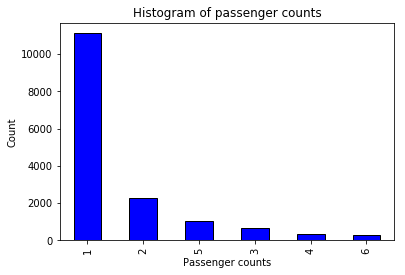

In [519]:
train['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k')
plt.title('Histogram of passenger counts')
plt.xlabel('Passenger counts')
plt.ylabel('Count')

#

Text(0.5, 1.0, 'Avg  trip rate on weekly basis')

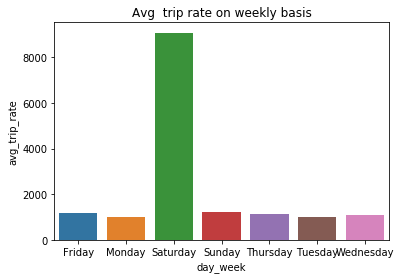

In [520]:
trips_day_fareamount=train.groupby(['day_week'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'avg_trip_rate'})
sns.barplot(x='day_week',y='avg_trip_rate',data=trips_day_fareamount).set_title("Avg  trip rate on weekly basis")

Text(0.5, 1.0, 'Avg trips over month')

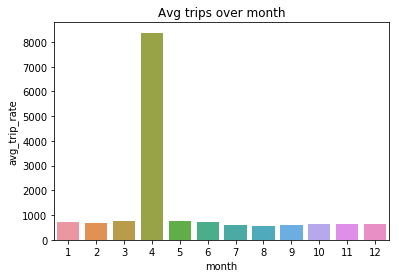

In [521]:
trips_month_fareamount=train.groupby(['month'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'avg_trip_rate'})
sns.barplot(x='month',y='avg_trip_rate',data=trips_month_fareamount).set_title("Avg trips over month")

Text(0.5, 1.0, 'Avg Fare Amount over month')

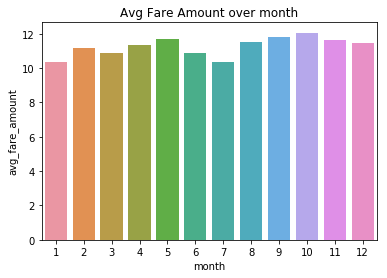

In [522]:
trips_month_fareamount=train.groupby(['month'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
sns.barplot(x='month',y='avg_fare_amount',data=trips_month_fareamount).set_title("Avg Fare Amount over month")

In [523]:
train.groupby('passenger_count').size()

passenger_count
1    11119
2     2279
3      661
4      319
5     1024
6      294
dtype: int64

Text(0.5, 1.0, 'trips_passenger_count')

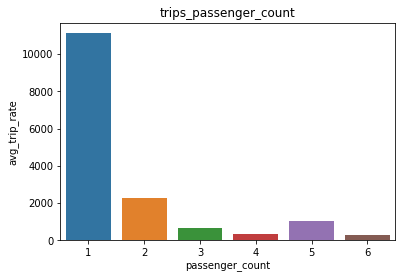

In [524]:
trips_passenger_count=train.groupby(['passenger_count'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'avg_trip_rate'})
sns.barplot(x='passenger_count',y='avg_trip_rate',data=trips_passenger_count).set_title("trips_passenger_count")

In [525]:
train.groupby('day_week').size()

day_week
Friday       1170
Monday        990
Saturday     9066
Sunday       1225
Thursday     1139
Tuesday      1024
Wednesday    1082
dtype: int64

In [526]:

train['day_week'] = train['day_week'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

test['day_week'] = test['day_week'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

train.shape

(15696, 14)

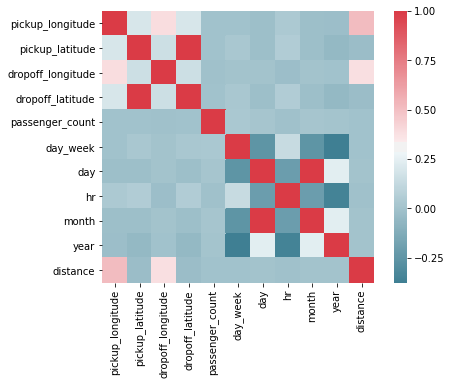

In [527]:

df_corr= train.drop(columns=['fare_amount'])
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [528]:

train=train.drop('date',axis=1)
test=test.drop('date',axis=1)




In [529]:

train=train.drop('pickup_datetime',axis=1)
test=test.drop('pickup_datetime',axis=1)



In [530]:
###################################BUILDING MODEL TO PREDICT FARE ####################################################

In [531]:
print(train.shape)
print(test.shape)
train.head()

(15696, 12)
(9914, 11)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_week,day,hr,month,year,distance
0,4.5,-73.844311,40.721319,-73.841610,40.721319,1,6,4,20,4,2009,0.227623
1,16.9,-74.016048,40.711303,-73.979268,40.711303,1,6,4,20,4,2009,3.100053
2,5.7,-73.982738,40.761270,-73.991242,40.761270,2,4,8,0,8,2011,0.716233
3,7.7,-73.987130,40.733143,-73.991567,40.733143,1,6,4,20,4,2009,0.373856
4,5.3,-73.968095,40.768008,-73.956655,40.768008,1,6,4,20,4,2009,0.963415


In [532]:
def distance_fare(df):
    df=df.drop(train[(train['H_Distance']==0)&(train['fare_amount']==0)].index, axis = 0)
    return df

def compute_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))


def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

def farerate_rmse(df, rate, name):
    print(name,":RMSE for fare rate is =",round(compute_rmse(df['fare_amount'],train['distance']*1.76+2.5),3))
    
    
def mean_squared_error(actual, predicted):
    return (np.mean((actual - predicted)**2))
    
    
rate = round(train['fare_amount'].mean() / train['distance'].mean(),3)

#fare = train['distance']*1.76+2.5
    
print("Rate = ${0}/km".format(rate))

farerate_rmse(train, rate, 'Train')

print("Train :MAPE for fare rate is =",round(MAPE(train['fare_amount'],rate * train['distance']),3))
error_table=pd.DataFrame(index=['MAPE','MSE','RMSE'])

error_table['ManualCalculation']=[round(MAPE(train['fare_amount'],train['distance']*1.76+2.5),3),mean_squared_error(train['fare_amount'], rate * train['distance']),compute_rmse(train['fare_amount'],rate * train['distance'] )]

Rate = $5.758/km
Train :RMSE for fare rate is = 8.6
Train :MAPE for fare rate is = 49.513


In [533]:
###################################LINEAR REGRESSION #################################################################
from sklearn.linear_model import LinearRegression

Y =train['fare_amount']
X = train.drop(columns=['fare_amount'])

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.3, random_state=40)

lr = LinearRegression().fit(X1_train, Y1_train)
predictions_LR = lr.predict(X1_test)


print("Test  MAPE after applying  Linear Regression : %.3f" % MAPE(Y1_test, predictions_LR))
print("Test  MSE after applying Linear Regression : %.3f" %  mean_squared_error(Y1_test, predictions_LR))
print("Test RMSE after applying Linear Regression  : %.3f" % compute_rmse(Y1_test, predictions_LR))

error_table['LR']=[MAPE(Y1_test, predictions_LR),mean_squared_error(Y1_test, predictions_LR),compute_rmse(Y1_test, predictions_LR)]

Test  MAPE after applying  Linear Regression : 39.183
Test  MSE after applying Linear Regression : 37.790
Test RMSE after applying Linear Regression  : 6.147


In [534]:
################################### DECISION TREE REGERESSION ########################################################

from sklearn.tree import DecisionTreeRegressor

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y, test_size=0.3, random_state=40)

fit_DT = DecisionTreeRegressor(max_depth=2).fit(X2_train,Y2_train)
predictions_DT = fit_DT.predict( X2_test)

print("Test  MAPE after applying  Decision Regression : %.3f" % MAPE(Y2_test, predictions_DT))
print("Test  MSE after applying Decision Regression : %.3f" %  mean_squared_error(Y2_test, predictions_DT))
print("Test RMSE after applying Decision Regression  : %.3f" % compute_rmse(Y2_test, predictions_DT))

error_table['DecisionTree']=[MAPE(Y2_test, predictions_DT),mean_squared_error(Y2_test, predictions_DT),compute_rmse(Y2_test, predictions_DT)]

Test  MAPE after applying  Decision Regression : 38.224
Test  MSE after applying Decision Regression : 31.058
Test RMSE after applying Decision Regression  : 5.573


In [535]:
################################# RANDOM FOREST ######################################################################
from sklearn.ensemble import RandomForestRegressor

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X, Y, test_size=0.3, random_state=40)


rf = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100).fit(X3_train, Y3_train)
predictions_RF = rf.predict(X3_test)

print("Test  MAPE after applying  Random Forest %.3f" % MAPE(Y3_test, predictions_RF))
print("Test  MSE after applying  Random Forest %.3f" %  mean_squared_error(Y3_test, predictions_RF))
print("Test RMSE after applying  Random Forest  : %.3f" % compute_rmse(Y3_test, predictions_RF))

error_table['RandomForest']=[MAPE(Y3_test, predictions_RF),mean_squared_error(Y3_test, predictions_RF),compute_rmse(Y3_test, predictions_RF)]

Test  MAPE after applying  Random Forest 38.269
Test  MSE after applying  Random Forest 30.106
Test RMSE after applying  Random Forest  : 5.487


In [536]:
################################ OLS MODEL IN LINEAR REGRESSION #####################################################
import statsmodels.api as sm

X4_train, X4_test, Y4_train, Y4_test = train_test_split(X, Y, test_size=0.3, random_state=40)

model = sm.OLS(Y4_train,X4_train).fit()

# make the predictions by the model
predictions_OLS = model.predict(X4_test)

print("Test  MAPE after applying  OLS %.3f" % MAPE(Y4_test, predictions_LR))
print("Test  MSE after applying  OLS %.3f" %  mean_squared_error(Y4_test, predictions_LR))
print("Test RMSE after applying  OLS  : %.3f" % compute_rmse(Y4_test, predictions_LR))

# Print out the statistics
print(model.summary())

error_table['OLS']=[MAPE(Y4_test, predictions_OLS),mean_squared_error(Y4_test, predictions_OLS),compute_rmse(Y4_test, predictions_OLS )]

Test  MAPE after applying  OLS 39.183
Test  MSE after applying  OLS 37.790
Test RMSE after applying  OLS  : 6.147
                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     4896.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        08:20:12   Log-Likelihood:                -36387.
No. Observations:               10987   AIC:                         7.279e+04
Df Residuals:                   10978   BIC:                         7.286e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------

In [537]:
error_table

,ManualCalculation,LR,DecisionTree,RandomForest,OLS
MAPE,44.169000,39.182607,38.223983,38.268799,39.142989
MSE,175.325563,37.790028,31.057557,30.106247,38.030192
RMSE,13.241056,6.147359,5.572931,5.486916,6.166862


In [538]:
'''based on the analysis we can fix random forest as the accurate model as the error rate is less'''

########################### PREDICTING THE FARE  AMOUNT of TEST DATE ################################################

test['fare_amount']=np.round(rf.predict(test),3)




In [539]:

test.to_csv("test_output.csv",index=False)

In [540]:
test['fare_amount'].describe()

count    9914.000000
mean       11.330610
std         7.524217
min         8.263000
25%         8.263000
50%         8.263000
75%        13.563000
max        51.010000
Name: fare_amount, dtype: float64

In [ ]:
#function to find the location details
    
    #calculate the month , day , year , weekday or weekend
    
    #df['pickup_datetime']=df.apply(lambda row: df['pickup_datetime'].mode() if (r.match('2009-06-15 17:26:21 UTC')) else row['pickup_datetime'],axis=1)
    #df['date']=df['pickup_datetime'].str.rsplit(" ", n=2, expand=True)[0]
    #df['time']=df['pickup_datetime'].str.rsplit(" ", n=2, expand=True)[1]
    #df['year']=df['date'].str.rsplit("-", n=3, expand=True)[0]
    #df['month']=pd.to_numeric(df['date'].str.rsplit("-", n=3, expand=True)[1])
    #df['day']=pd.to_numeric(df['date'].str.rsplit("-", n=3, expand=True)[2])
    #df['hr']=pd.to_numeric(df['time'].str.rsplit(":", n=2, expand=True)[0])
    
    #df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    #df['day_week']=df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    
    
    
    #function to validate and current the month,hr,day and also missing value 

    
    #df["date"]=df.apply(lambda row: droprows(df,"date") if (row["date"] is null) else row["month"],axis=1)
    
    
    
    
#def calculateLocation(lat1,long1):
 #       geolocator = Nominatim(user_agent="specify_your_app_name_here",timeout=3)
  #      return geolocator.reverse(lat1,long1)

#translator = Translator()
#def location_locality(location,x):
 #   return loctranslator.translate(location.raw['address'][x]).text
    
    

#calculate the min and max of lat in test data
#lat_min=min(test.pickup_latitude.min(),test.dropoff_latitude.min())
#lat_max=max(test.pickup_latitude.max(),test.dropoff_latitude.max())

''' 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

logit = sm.Logit(Y_train ,X_train).fit()

logit.summary()


def normalize(df):
    cnames = ["fare_amount","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","day_week",
           "day","hr","month","year","distance"]
    for i in cnames:
            df[i] = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))
    return df

'''

